In [5]:
# Import all packages 
import numpy as np
import pandas as pd
import os as os
import seaborn as sns
import sys
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.transforms import Bbox
from skimage import data, exposure, img_as_float
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tifffile import imread
import glob
import cv2
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar



# Make plots look good 
%config InlineBackend.figure_format = 'svg'
sns.set_style("whitegrid")
sns.set_context("paper")

In [ ]:
#ND2 to tif

In [11]:
# functions 


def plot_channels(u):

    # Make a wider figure so we can fit in subplots
    plt.figure(figsize=(18, 15))

    # Show each of the three channels
    n_channels = len(u)

    for ii in range(n_channels):

        # Subplot indices start at 1
        plt.subplot(2, int(n_channels/2), ii+1)
	    
        # Array indices start at 0
        u_channel = u[ii]
        plt.imshow(u_channel)
        plt.title(f'Channel {ii}')
        plt.axis(False)

    plt.show()

def colorize(u, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if u.ndim > 2 and u.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')
        
    # Rescale the image according to how we want to display it
    u_scaled = u.astype(np.float32) - np.percentile(u, clip_percentile)
    u_scaled = u_scaled / np.percentile(u_scaled, 100 - clip_percentile)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    # Need to make sure we have a channels dimension for the multiplication to work
    u_scaled = np.atleast_3d(u_scaled)
    
    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return u_scaled * color
    
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y


def rescale_by_percent_and_cut_off(u,min_percent= 0,max_percent= 100,min_cut=0,max_cut=0):
    
    if min_cut == 0 and min_cut == 0:
        min_cut = u.min()
        max_cut = u.max()

    
    u[u<=min_cut] = 0  # Subtract the minimum
    u[u>max_cut] = max_cut # Subtract the minimum
    
    
    u_scaled = u.astype(np.float32) - np.percentile(u, min_percent)
    u_scaled = u_scaled / np.percentile(u_scaled, max_percent)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    
#     u_divided = u / max_cut  # Divide by new max
    u_inf = np.iinfo(u.dtype)
    u_multiplied = u_scaled * (2**u_inf.bits) # Multiply by dtype max
    
    u_final = u_scaled#exposure.rescale_intensity(u_rescaled, in_range=tuple(percentiles))
    return u_multiplied

def crop_im(u,y1,y2,x1,x2):

    n_channels = len(u)

    u_crop= (u[0][y1:y2,x1:x2],)

    if n_channels > 1:
        for i in range(1,n_channels):
                u_crop = u_crop + (u[i][y1:y2,x1:x2],)

    u_crop = np.stack(u_crop)

    return u_crop


def scalebar(ax,microns,Image_pixel_size):

    scalebar = AnchoredSizeBar(ax.transData,
                               microns/Image_pixel_size, str(microns) + 'um', 'lower right',
                               pad=0.1,
                               color='k',
                               frameon=False,
                               size_vertical=1,
                          bbox_to_anchor=Bbox.from_bounds(0, 0, 1, 1),
                          bbox_transform=ax.figure.transFigure)

    ax.add_artist(scalebar)

def plot_and_save(im_c_c,path_to_save,microns,Image_pixel_size,fig_title,multi):
    fig ,ax= plt.subplots()
    fig.suptitle(fig_title)
    if multi == 1:
        plt.imshow(im_c_c)
    else:
        plt.imshow(im_c_c, cmap='gray')
        
    plt.axis(False)
    scalebar(ax,microns,Image_pixel_size)
    plt.show()
    fig.savefig( path_to_save, dpi=1200,format = 'pdf')


In [4]:
# Save each channel as a .tif

TypeError: Invalid shape (0,) for image data

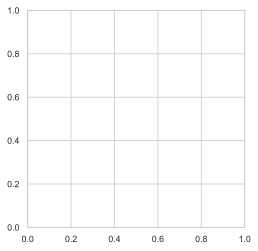

In [12]:
import nd2reader
import tifffile

# File paths
nd2_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Committed_colony_4.nd2'
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Committed_colony_4'

# Read the .nd2 file
nd2 = nd2reader.ND2Reader(nd2_file_path)

# Extract the image data
# Assuming you want to extract a specific channel, say channel 0
# Adjust the channel index as needed
c_ = 0
image_data = nd2.get_frame_2D(c=c_)  # 'c' is the channel number

# Save the image data as a .tif file
tifffile.imwrite(tif_file_path + 'c_'+str(c_) + '.tif', image_data)

c_ = 1
image_data = nd2.get_frame_2D(c=c_)  # 'c' is the channel number

# Save the image data as a .tif file
tifffile.imwrite(tif_file_path + 'c_'+str(c_) + '.tif', image_data)

c_ = 2
image_data = nd2.get_frame_2D(c=c_)  # 'c' is the channel number

# Save the image data as a .tif file
tifffile.imwrite(tif_file_path + 'c_'+str(c_) + '.tif', image_data)

# Close the nd2 reader
nd2.close()

In [7]:
# Scale bar

microns = 100
Image_pixel_size = 6.5
objective = 20
Image_pixel_size = Image_pixel_size * 2 / (objective * 1 * 1)
Image_pixel_size

0.65

Channel = 0
Channel = 1
Channel = 2
Merge


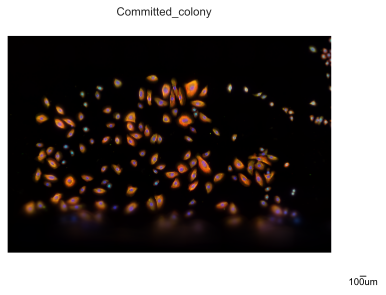

In [16]:
import nd2reader
import tifffile

# File paths
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Colony_4/Committed_colony_4_'



# large Dapi

c_= 0
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c'+str(c_) + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


c_= 1
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c'+str(c_) + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 60,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

c_= 2
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c'+str(c_) + '.tif')


im_c_c = rescale_by_percent_and_cut_off(im,min_percent= 0,max_percent= 99.9,min_cut=0,max_cut=0)  #
im_KI67 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

print('Merge')
im_white  = colorize(im_FN1 , (0, 1, 0))/1.3
im_red  = colorize(im_KI67 , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red, 0, 1)


path_to_save = '/Users/raul/Desktop/96well_mask/IF/figure_KI67_KRT14_small.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)

Channel = 0
Channel = 1
Channel = 2
Merge


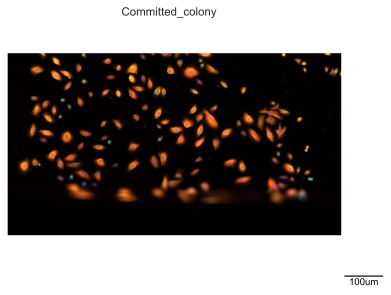

In [10]:
import nd2reader
import tifffile

# File paths
tif_file_path = '/Users/raul/Desktop/96well_mask/well1_KI67_KRT14/crops/channel_'
#'/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Committed_colony_3'
#'/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Expanding_colony_repeat'

# large Dapi
C = '_crop_8'
c_= 0
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


c_= 1
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 60,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

c_= 2
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')


im_c_c = rescale_by_percent_and_cut_off(im,min_percent= 0,max_percent= 99,min_cut=0,max_cut=0)  #
im_KI67 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

print('Merge')
im_white  = colorize(im_FN1 , (0, 1, 0))/1.1
im_red  = colorize(im_KI67 , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red, 0, 1)


path_to_save = '/Users/raul/Desktop/96well_mask/IF/test_3.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)

Channel = 0
Channel = 1
Channel = 2
Merge


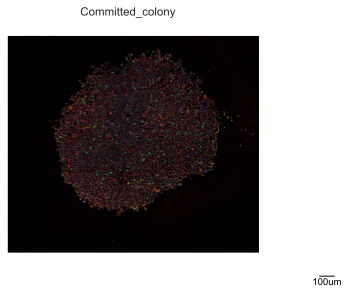

In [63]:
import nd2reader
import tifffile

# File paths
tif_file_path = '/Users/raul/Desktop/96well_mask/well1_KI67_KRT14/crops/channel_'
#'/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Committed_colony_3'
#'/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Expanding_colony_repeat'

# large Dapi
C = '_crop_14'
c_= 0
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


c_= 1
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 60,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

c_= 2
print('Channel = ' + str(c_))
im =  imread(tif_file_path +str(c_) +str(C)  + '.tif')


im_c_c = rescale_by_percent_and_cut_off(im,min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_KI67 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

print('Merge')
im_white  = colorize(im_FN1 , (0, 1, 0))
im_red  = colorize(im_KI67 , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red, 0, 1)


path_to_save = '/Users/raul/Desktop/96well_mask/IF/test.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)

Channel = 0
Channel = 1
Channel = 2
Merge


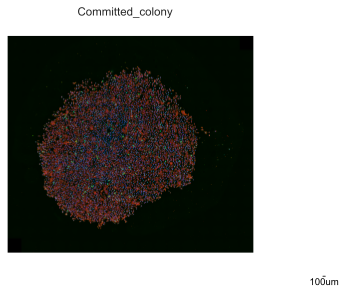

In [9]:
import nd2reader
import tifffile

# File paths
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Expanding_colony_repeat'

# large Dapi

c_= 0
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c_'+str(c_) + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


c_= 1
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c_'+str(c_) + '.tif')



im_c_c= rescale_by_percent_and_cut_off(im,min_percent= 0,max_percent= 100,min_cut=0,max_cut=64254)  #
im_FN1 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

c_= 2
print('Channel = ' + str(c_))
im =  imread(tif_file_path + 'c_'+str(c_) + '.tif')


im_c_c = rescale_by_percent_and_cut_off(im,min_percent= 0,max_percent= 100,min_cut=10507,max_cut=54587)  #
im_KI67 = im_c_c#gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

print('Merge')
im_white  = colorize(im_FN1 , (0, 1, 0))/1.5
im_red  = colorize(im_KI67 , (1, 0, 0))/1.5
im_composite = np.clip(im_blue +im_white + im_red, 0, 1)


path_to_save = '/Users/raul/Desktop/96well_mask/IF/test1.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)

In [5]:
import cv2
import numpy as np

def apply_histogram_stretching(image):
    min_val, max_val = np.min(image), np.max(image)
    LUT = np.zeros(256, dtype='uint8')
    for i in range(256):
        LUT[i] = int((255/(max_val-min_val)) * (i - min_val))
    stretched_image = LUT[image]
    return stretched_image

# File paths
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Colony_4/Committed_colony_4_'
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Expanding_colony_repeat'

# Load the images
c_= 0
image1 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)
c_= 1
image2 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)
c_= 2
image3 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)

# Apply histogram stretching to each image individually
stretched_image1 = apply_histogram_stretching(image1)
stretched_image2 = apply_histogram_stretching(image2)
stretched_image3 = apply_histogram_stretching(image3)

# Merge the stretched images into a color image
merged_image = cv2.merge([stretched_image1, stretched_image2, stretched_image3])

# Display the merged image
#cv2.imshow('Merged Image', merged_image)
#cv2.waitKey(1)
#cv2.destroyAllWindows()

# Save the merged image (optional)
cv2.imwrite('/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RARKRT14/sLarge_clone.jpg', merged_image)




True

In [1]:
import cv2
import numpy as np

# File paths
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Colony_4/Committed_colony_4_'
tif_file_path = '/Volumes/rag_big_2/Raul/20231106_STR_K14_KI67/Expanding_colony_repeat'

# Load the images
c_= 0
image1 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)
c_= 1
image2 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)
c_= 2
image3 = cv2.imread(tif_file_path + 'c_'+str(c_) + '.tif', 0)

# Define brightness and contrast adjustment values (adjust as needed)
brightness_value = 0  # Increase brightness by 50
contrast_value = 1.5  # Increase contrast by 50%

# Apply brightness and contrast adjustments to each image
adjusted_image1 = image2#cv2.convertScaleAbs(image1, alpha=contrast_value, beta=brightness_value)
adjusted_image2 = image2#cv2.convertScaleAbs(image2, alpha=contrast_value, beta=brightness_value)
adjusted_image3 = cv2.convertScaleAbs(image3, alpha=contrast_value, beta=brightness_value)

# Merge the adjusted images into a color image
merged_image = cv2.merge([adjusted_image1, adjusted_image2, adjusted_image3])

# Save the merged image (optional)
cv2.imwrite('/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RARKRT14/small_clone.jpg', merged_image)



True